# Hyperbolic Discounting in ``respy``

In this notebook we will show how to set up, solve, simulate and estimate a simple discrete-choice dynamic programming model for a completely naïve agent with time-inconsistent preferences using ``respy`` and ``estimagic``. 

1. [Introduction](#1)<br>
2. [Basic Robinson Crusoe Economy](#2)<br> 
  2.1. [Model](#2.1)<br> 
  2.2. [Specification](#2.2)<br> 
  2.3. [Simulation and Analysis](#2.3)<br>
3. [Extended Robinson Crusoe Economy](#3)<br>
  3.1. [Model](#3.1)<br>
  3.2. [Specification](#3.2)<br>
  3.3. [Simulation and Analysis](#3.3)<br>
4. [Estimation](#4)<br>

## 1. Introduction <a class="anchor" id="1"></a>

People are impatient, and tend to prefer immediate rewards and delayed costs. People also tend to experience reversals of preferences, that is, to prefer a larger and later reward to a smaller and earlier one, as long as the rewards are distant in time; but to prefer the smaller and earlier rewards as soon as both rewards get closer in time *(add source on OPR?)*.
While the former feature is captured by exponential discounting — the assumption that people discount streams of utility over time exponentially —, the latter is not: Exponential discounting implies time-consistent preferences.

An attractive representation consistent with both these features, introduced by Phelps and Pollak (1968) and later employed by Laibson (1997) and O’Donoghue and Rabin's (1999), are *hyperbolic* discount functions, also known ($\beta$-$\delta$) preferences:

$$
    U_t(u_t, u_{t+1}, ...) \equiv u_t + \beta \sum^{T}_{k=t+1}
            {\delta^{k-t}u_k}
$$

where $\beta \in (0, 1]$ is the present-bias factor that captures time-inconsistent discounting (or present-bias, or impatience), and $\delta \in (0, 1]$ is the usual long-run discount factor. Time-consistent discounting is represented by the special case where $\beta = 1$. 

Time-inconsistent agents can be modelled as consisting of multiple selves: The current self controls the actions of the agent, which will be observed in the data, but her decisions depends on her beliefs over the behavior of the future selves, which may or may not share the same time preferences. The agent is **completely sophisticated** if she correctly anticipates her future selves to discount according to $\beta$, **partially sophisticated** if she anticipates $\tilde\beta > \beta$, and **completely naïve** is she anticipates $\beta = 1$, that is, she anticipates her future selves to behave time-consistently.

In the following, we will focus on solving, simulating and estimating a discrete choice dynamic programming model for a completely naïve agent with time-inconsistent preferences. Similar models have been proposed in a variety of different settings including mammograpy decisions (Fang and Wang, 2010), welfare participation (Fang and Silverman, 2007, and Chan, 2017), job search (Paserman, 2008), life-cycle consumption choices (Laibson *et al.*, 2005) and response to health interventions (Mahajan and Tarozzi, 2011).

In [1]:
%matplotlib inline

import io
import pandas as pd
import respy as rp
import numpy as np

from estimagic.optimization.optimize import maximize

from python.auxiliary import plot_robinson_choices_base
from python.auxiliary import plot_return_experience
from python.auxiliary import plot_myopic_vs_present_bias
from python.auxiliary import plot_robinson_choices_extended
from python.auxiliary import compute_profile_likelihood
from python.auxiliary import plot_profile_likelihood

## 2. Basic Robinson Crusoe Economy <a class="anchor" id="2"></a>

### 2.1. Model <a class="anchor" id="2.1"></a>

We start with a basic Robinson Crusoe economy, where Robinson is alone on a desert island and each day must choose between two alternatives: going fishing ($a=1$) or spending the day on his hammock ($a=0$). The istantaneous utility of a choice, $u_t$, consists of the sum of a wage component $W_t$ and a non-pecuniary component $N_t$, which in turn depend on Robinson's current state $s_t$ and chosen alternative $a_t$. 

The current state contains information on all the observed and unobserved characteristics of the model and here it is limited to the current period $t$, Robinson's experience in fishing, his choice in the previous period $t-1$, and the vector of choice-specific shocks. We refer to Robinson's observed characteristics, such as his experience in fishing, as covariates.

The **wage component** is zero if Robinson chooses to spend the day on his hammock, while if Robinson goes fishing his wage at time $t$ is:

$$\begin{align}
        W^f  &= \exp\{x^f_t \beta^f + \epsilon^f_t\} \\
\end{align}$$

where the superscript $f$ indicates the "fishing" alternative. The skill units are generated by the (exponentiated) dot product of $x^f_{t}$, a vector of choice- and time-dependent covariates, and $\beta^f$, the associated vector of choice-dependent parameters, plus a random shock $\epsilon^f_{t}$ drawn from a Normal distribution. In this basic Robinson Crusoe economy, $W^f$ is determined by only one covariate, Robinson's experience in fishing, and its associated return to experience.

The **non-pecuniary component** for fishing and relaxing on the hammock at time $t$ are also the vector dot product of covariates $x^h_{t}$ and parameters $\beta^h$, with an additional random shock entering the latter additively. In this simple model, we set both to constants. We also introduce a penalty to reflect the difficulty of storing food on a tropical island: Robinson incurs a loss $\gamma$ if he spends two days in a row on his hammock. 

$$
    N^f= \alpha^f \\
    N^h_t=   \left\{
    \begin{array}{ll}
    \alpha^h + \epsilon^h_{t} & a_{t-1}=1\\
    \alpha^h - \gamma + \epsilon^h_{t} & a_{t-1}=0\\
    \end{array} 
\right.  $$

where the superscript $h$ indicates the "hammock" alternative. 

Robinson maximizes his (expected) sum of discounted lifetime utilities; however, he is assumed to be an **hyperbolic discounter** who is additionally **completely naïve** with respect to his own time preferences, that is, at each point in time believes he will act time-consistently in future periods. Therefore, Robinson believes that his future selves will maximize:

$$
    U_t(u_t, u_{t+1}, ...) \equiv \sum^{T}_{t=0}
            {\delta^{t}u_t}
$$

while in each period he actually maximizes:

$$
    U_t(u_t, u_{t+1}, ...) \equiv u_t + \beta \sum^{T}_{k=t+1}
            {\delta^{k-t}u_k}
$$

The parameters of this simple model are $\alpha^f$ and $\alpha^h$ (the constants in the non-pecuniary components) and $\beta^f$ (return to experience in fishing), along with $\beta$ and $\delta$ (time-preference parameters) and the lower triangular elements of the shocks variance-covariance matrix (which governs the distribution of the shocks). Note that shocks are allowed to be correlated across choices.

### 2.2. Specifications <a class="anchor" id="2.2"></a>

We now write the model's parameters to a ``.csv`` file and load it with ``pandas``. The resulting DataFrame contains a two-level MultiIndex to group parameters (identified by a unique ``name`` and ``value``) in categories. In particult, ``"delta"`` and ``"beta"`` represents Robinson's time preferences. Below, we set ``"beta"`` to 0.8. 

In [2]:
params_beta = """
category,name,value
beta,beta, 0.8
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1
"""

In [3]:
params_beta = pd.read_csv(io.StringIO(params_beta), index_col=["category", "name"])
params_beta

value
category                name                          
beta                    beta                      0.80
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

In the literature, the range of the point estimates for $\beta$ is quite wide. Laibson *et al.* (2005) estimates based on life-cycle consumption choices range between 0.51 and 0.82, while Fang and Silverman (2007) and Paserman (2008), when estimating respectively models of welfare participation for single mothers and job search for low-wage workers, recover estimates closer to 0.4.

We will compare the behavior of:

1. A time-consistent Robinson (``"beta"``= 1)
2. A Robinson with present bias equal to 0.8
3. A Robinson with present bias equal to 0.5

Therefore, we will need two additional sets of ``params``.

In [4]:
# Set of parameters for time-consistent Robinson (as beta is read by default as 1)
params = params_beta.drop(labels="beta", level="category")

# Set of parameters for very impatient Robinson
params_lowbeta = params_beta.copy()
params_lowbeta.loc[("beta", "beta"), "value"] = 0.5

The ``options`` specifications complement ``params`` with additional information needed to solve and simulate the model, incluiding the number of periods for which decision rules are computed, the number of simulated individuals, and, importantly, the two seeds for the solution and simulation of the model.

We load the default options for the basic model. Using the same ``options`` ensures comparability across the three Robinsons' pattern of choices, as the shocks are always the same for each of the three simulations -- and therefore, differences across behavior are solely driven by the different ``"beta"``.

In [5]:
_, options = rp.get_example_model("robinson_crusoe_basic", with_data=False)

### 2.3. Simulation and Analysis <a class="anchor" id="2.3"></a>

We start by simulating the basic model for our three Robinsons.

In [6]:
# Simulation for time-consistent Robinson
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

In [7]:
# Simulation for impatient Robinson
simulate = rp.get_simulate_func(params_beta, options)
df_beta = simulate(params_beta)

In [8]:
# Simulation for very impatient Robinson
simulate = rp.get_simulate_func(params_lowbeta, options)
df_lowbeta = simulate(params_lowbeta)

We can then compare their decisions period by period with the visualizations below.

***
_Choice Pattern_

***

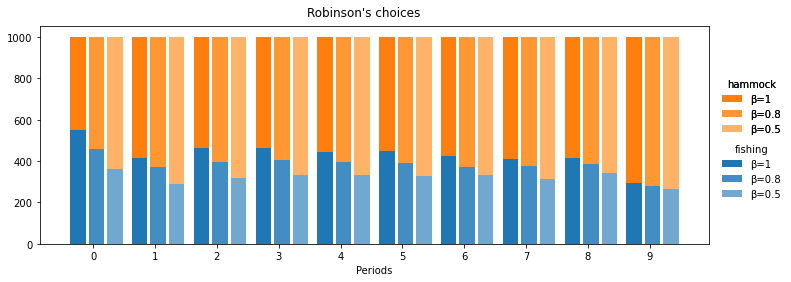

In [9]:
plot_robinson_choices_base(df, df_beta, df_lowbeta)

Note that in ``params`` we specified ``"nonpec_fishing"`` to be negative, and therefore a cost, while ``"nonpec_hammock"`` is positive, and therefore a reward. However, Robinson cannot enjoy his reward (relaxing on the hammock) two periods in a row without incurring in a penalty. 

As naïve hyperbolic discounters tend to procrastinate immediate costs and preproperate immediate rewards, it's no surprise that both present-biased Robinsons are less likely to go fishing than the time-consistent Robinson in each period. 

***
_Different returns to experience_
***

In [10]:
# Specification of grid for evaluation
n_points = 15    
grid_start = 0
grid_stop = 0.3

grid_points = np.linspace(grid_start, grid_stop, n_points)

mean_max_exp_fishing_by_beta = []
for p in [params.copy(), params_beta.copy(), params_lowbeta.copy()]:
    mean_max_exp_fishing = []
    for value in grid_points:
        p.loc["wage_fishing", "exp_fishing"] = value
        df_sim = simulate(p)
        stat = df_sim.groupby("Identifier")["Experience_Fishing"].max().mean()
        mean_max_exp_fishing.append(stat)
    mean_max_exp_fishing_by_beta.append(mean_max_exp_fishing)

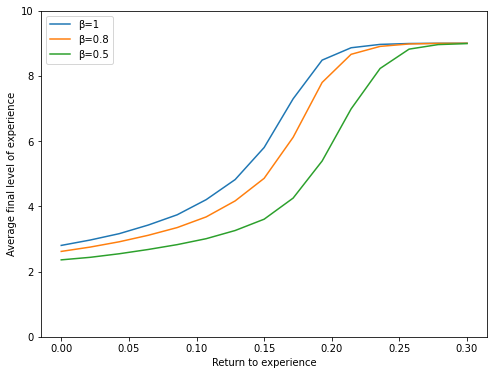

In [11]:
plot_return_experience(mean_max_exp_fishing_by_beta, grid_points)

For the same return to experience, time-inconsistent Robinsons attain lower average level of final experience, with the behavior of the most present-biased Robinson obviously being the least reactive to an increasing return to experience. As accumulating experience in fishing, which involves an immediate cost, is the prerequisite to enjoy higher returns, a severely present-biased Robinson has little interest in accumulating such experience in the first place. However, when the return to experience is 0.3, the three Robinsons spend all their time fishing.

***
_Comparison with completely myiopic agent_
***

We've seen that a present-bias agent discounts the stream of utility from future periods while falsely believing, at each point in time, that he will act time-consistently in future period. Therefore, he evaluates the sum of his discounted lifetime utility under the conviction that the future streams of utility will arise from time-consistent behavior, and choose the current alternative accordingly.

On the other hand, a completely myopic agent, whose preferences are represented by a $\delta$ equal to 0, simply chooses the alternative that provides the higher (flow) utility today, without making any assumption about his future behavior nor putting any weight on his future utility: The DCDP model collapse to the static case (Keane, Todd and Wolpin, 2011). 

We may want to compare the pattern of behavior produced by an high degree of present bias, to that produced by a completely myopic agent.

In [12]:
# Set of parameters for myopic Robinson
params_myopic = params.copy()
params_myopic.loc[("delta", "delta"), "value"] = 0

In [13]:
# Simulation for myopic Robinson
simulate = rp.get_simulate_func(params_myopic, options)
df_myopic = simulate(params_myopic)

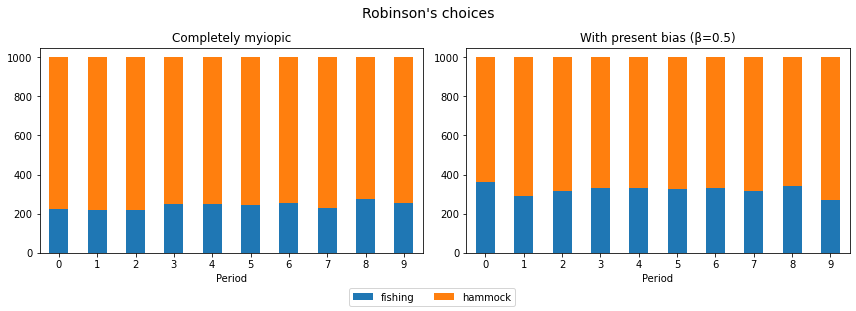

In [14]:
plot_myopic_vs_present_bias(df_myopic, df_lowbeta)

In this basic Robinson Crusoe economy (and for this set of parameters) the classical model requires a very, very low $\delta$ for Robinson to fish in few periods, while a similarly low fishing time can be produced by more reasonable parameters in the hyperbolic discounting setting. As noted by Rabin (2002), exponential discounting is essentially a theory of infinite patience in the short-term, since assuming even *some* taste for immediate gratification translates into extremely low yearly discount rate. 

Obviously, the behavior of completely myopic and present-biased Robinson grows increasingly different the larger the return to experience: present-biased Robinson spends much more time fishing than completely myopic Robinson, as the former has still an interest in accumulating fishing experience despite his high present bias. 

***
_Welfare loss_ 
***

**(needs to be checked)**

Before moving to the next section, we briefly touch the issue of welfare loss. As noted in O'Donoghue and Rabin (1999), welfare comparisons for hyperbolic discounters are in principle problematic, precisely because time preferences are dynamically inconsistent and a certain strategy may make some selves better off while making other selves worse off. Strong criteria such as Pareto-efficiency, which ranks as "best" a strategy which is (weakly) preferred by all selves, may be not informative. 

O'Donoghue and Rabin take a "long-run perspective" to compare welfare outcomes, weighting the instantaneous utility in all future periods equally, such that no self is more important than another. 

In [15]:
results = []

for series in [df, df_beta, df_lowbeta, df_myopic]:
    utility_fishing = series[series["Choice"]=="fishing"].groupby("Period").Flow_Utility_Fishing.mean().sum()
    utility_hammock = series[series["Choice"]=="hammock"].groupby("Period").Flow_Utility_Hammock.mean().sum()
    welfare = utility_fishing + utility_hammock
    results.append(welfare)
    
    welfare_loss = results[0] - welfare
    results.append(welfare_loss)

pd.DataFrame(np.reshape(results, (4,2)), columns=["Welfare", "Welfare Loss"], index=["β=1", "β=0.8", "β=0.5", "δ=0"])     

,Welfare,Welfare Loss
β=1,49.987814,0.000000
β=0.8,50.091398,-0.103584
β=0.5,50.854637,-0.866824
δ=0,53.616968,-3.629154


We can see that the perfectly forward-looking Robinson is outperformed by the others. However, we set the return to experience to be very low: The current parametrization leaves Robinson with little incentive to invest his time in fishing. Increasing ``exp_fishing`` changes the picture.

In [16]:
results = []

for p in [params.copy(), params_beta.copy(), params_lowbeta.copy(), params_myopic.copy()]:
    p.loc[("wage_fishing","exp_fishing"), "value"] = 0.2
    simulate = rp.get_simulate_func(p, options)
    series = simulate(p)
    utility_fishing = series[series["Choice"]=="fishing"].groupby("Period").Flow_Utility_Fishing.mean().sum()
    utility_hammock = series[series["Choice"]=="hammock"].groupby("Period").Flow_Utility_Hammock.mean().sum()
    welfare = utility_fishing + utility_hammock
    results.append(welfare)
    
    welfare_loss = results[0] - welfare
    results.append(welfare_loss)

pd.DataFrame(np.reshape(results, (4,2)), columns=["Welfare", "Welfare Loss"], index=["β=1", "β=0.8", "β=0.5", "δ=0"])     

,Welfare,Welfare Loss
β=1,79.788725,0.000000
β=0.8,77.609941,2.178784
β=0.5,66.055342,13.733383
δ=0,58.520763,21.267962


Indeed, for a return to experience in fishing of 0.2 (double the starting value) the welfare loss with respect to the perfectly forward-looking strategy becomes more and more sizable the less weight Robinson puts on future periods.

## 3. Extended Model  <a class="anchor" id="3"></a>

### 3.1. Model <a class="anchor" id="3.1"></a>

We extend the basic model to include a new alternative to the choice set: Robinson can now ask Friday, an experience fisherman, for help, but only once and only if Robinson has been fishing before. The interaction with Friday increases the return to experience in fishing, which in turn will increase $W^f$ in future periods, but enters negatively Robinson's utility function in the current period. Indeed, its **wage component** is zero, while its **non-pecuniary component** is a negative, to reflect the effort costs of learning and the food penalty:

This time we compare the behavior of a time-consistent Robinson with that of a time-inconsistent Robinson with ``"beta"`` = 0.8. Given these extensions and what we have already seen in the basic model, we expect:

- Time-inconsistent Robinson to be less likely to interact with Friday, as costs are procrastinated;
- Time-inconsistent Robinson to incur in a welfare loss with respect to time-consistent Robinson, since not interacting with Friday means a lower return to experience in fishing and therefore a lower $W^f$ in future periods.

### 3.2. Specifications <a class="anchor" id="3.2"></a>

First, we load the model's options and parameters for the former. Now ``params_ext`` include an additional ``category``, ``"nonpec_friday"``, which is indeed set to a negative value, while ``"contemplation_with_friday"`` under ``"wage_fishing"`` is set to a positive value. The additional restrictions to Robinson's interaction with Friday are mapped to ``options_ext``.

In [17]:
params_ext, options_ext = rp.get_example_model("robinson_crusoe_extended", with_data=False)

Then, we create another set of parameters for time-inconsistent Robinson, who differs from the previous one only in the value of ``"beta"``:

In [18]:
index = pd.MultiIndex.from_tuples([("beta", "beta")], names=["category", "name"])
beta = pd.DataFrame(0.8, index=index, columns=["value"])
params_beta_ext = beta.append(params_ext)

### 3.3. Simulation and Analysis <a class="anchor" id="3.3"></a>

Again, we simulate the model for time-consistent and for time-inconsistent Robinson:

In [19]:
simulate = rp.get_simulate_func(params_ext, options_ext)
df_ext = simulate(params_ext)

In [20]:
simulate = rp.get_simulate_func(params_beta_ext, options_ext)
df_beta_ext = simulate(params_beta_ext)

***
_Choice pattern_
***

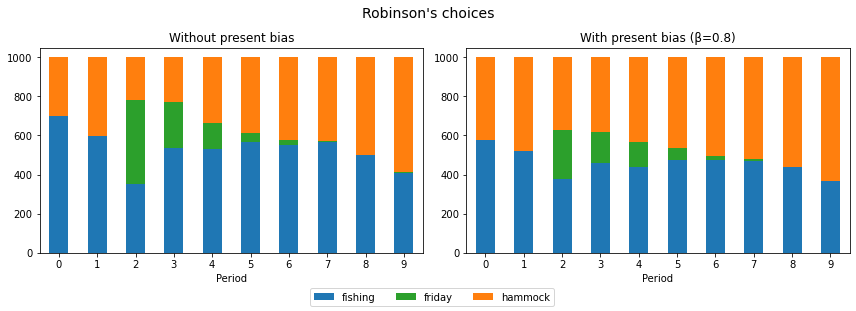

In [21]:
plot_robinson_choices_extended(df_ext, df_beta_ext)

Unsurprisingly, a Robinson who's a completely naïve, time-inconsistent discounter is less likely to interact with Friday, who would teach him how to fish but affect Robinson's utility negatively in that period. For a present-bias of 0.5 Robinson almost never interacts with Friday.

***
_Welfare loss_
***

In [22]:
results = []

for series in [df_ext, df_beta_ext]:
    utility_fishing = series[series["Choice"]=="fishing"].groupby("Period").Flow_Utility_Fishing.mean().sum()
    utility_hammock = series[series["Choice"]=="hammock"].groupby("Period").Flow_Utility_Hammock.mean().sum()
    welfare = utility_fishing + utility_hammock
    results.append(welfare)
    
    welfare_loss = results[0] - welfare
    results.append(welfare_loss)
    
pd.DataFrame(np.reshape(results, (2,2)), columns=["Welfare", "Welfare Loss"], index=["β=1", "β=0.8"])     

,Welfare,Welfare Loss
β=1,58.674299,0.000000
β=0.8,55.885651,2.788648


Again, unsurprisingly, time-inconsistent Robinson bears some welfare loss even for a moderate present-bias (the gap increases with a larger $\beta$).

## 4. Estimation <a class="anchor" id="4"></a>

**Work in progress.**

In [23]:
# Get the criterion function 
crit_func = rp.get_crit_func(params_beta_ext, options_ext, df_beta_ext)

# Constrain shock parameters to have valid variances and correlation
constr = rp.get_parameter_constraints("robinson_crusoe")

In [24]:
results_sim, estimates_sim = maximize(
    crit_func, params_beta_ext,
    "scipy_L-BFGS-B",
    algo_options={"maxfun": 100},
    constraints=constr,
    dashboard=False
)

In [25]:
estimated_params = pd.DataFrame(estimates_sim["value"]).rename(columns={"value":"estimate"})
true_params = pd.DataFrame(params_beta_ext["value"]).rename(columns={"value":"true value"})
comparison = pd.concat([estimated_params, true_params], axis=1)

comparison

estimate  true value
category                name                                            
beta                    beta                        0.794095        0.80
delta                   delta                       0.954747        0.95
wage_fishing            exp_fishing                 0.106429        0.10
                        contemplation_with_friday   0.372352        0.40
nonpec_fishing          constant                   -1.020948       -1.00
nonpec_friday           constant                   -0.963576       -1.00
                        not_fishing_last_period    -0.959206       -1.00
nonpec_hammock          constant                    2.484162        2.50
                        not_fishing_last_period    -1.007896       -1.00
shocks_sdcorr           sd_fishing                  0.985982        1.00
                        sd_friday                   1.070354        1.00
                        sd_hammock                  1.027088        1.00
                        corr_friday_fishing        -0.043361        0.00
                        corr_hammock_fishing        0.025632        0.00
                        corr_hammock_friday        -0.053158        0.00
lagged_choice_1_hammock constant                    1.000000        1.00
inadmissibility_penalty inadmissibility_penalty   -20.000000      -20.00

In [26]:
params_sim = params_beta_ext.copy()
params_sim["lower"] = params_sim["value"].values
params_sim["upper"] = params_sim["value"].values
params_sim.loc[["beta", "delta"],"lower"] = [0.794, 0.948]
params_sim.loc[["beta", "delta"],"upper"] = [0.802, 0.955]

In [27]:
results_sim = compute_profile_likelihood(params_sim, options_ext, df_beta_ext)

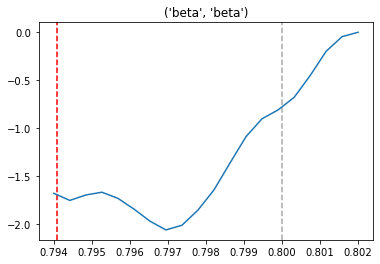

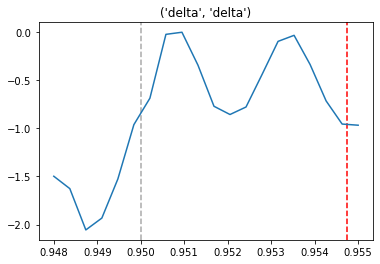

In [28]:
plot_profile_likelihood(results_sim, params_sim, estimates_sim)

The grey line indicates the true value, the red line indicates the value recovered by ML estimation.

***
*Simulated vs. observed data*
***

Fitting the model on an "observed" dataset (generated by the same model, but with a different simulation seed). No perturbation of true parameters at this stage.

In [29]:
# Generate "observed" data
options_obs = options_ext.copy()
options_obs["simulation_seed"] = 24

simulate = rp.get_simulate_func(params_beta_ext, options_obs)
df_obs = simulate(params_beta_ext)

In [30]:
# Get the criterion function 
crit_func = rp.get_crit_func(params_beta_ext, options_ext, df_obs)

In [31]:
results_obs, estimates_obs = maximize(
    crit_func, params_beta_ext,
    "scipy_L-BFGS-B",
    algo_options={"maxfun": 100},
    constraints=constr,
    dashboard=False
)

In [32]:
estimated_params_obs = pd.DataFrame(estimates_obs["value"]).rename(columns={"value":"estimate"})
comparison_obs = pd.concat([estimated_params_obs, true_params], axis=1)

comparison_obs

estimate  true value
category                name                                            
beta                    beta                        0.790348        0.80
delta                   delta                       0.952525        0.95
wage_fishing            exp_fishing                 0.099880        0.10
                        contemplation_with_friday   0.389495        0.40
nonpec_fishing          constant                   -1.001236       -1.00
nonpec_friday           constant                   -0.967824       -1.00
                        not_fishing_last_period    -0.992094       -1.00
nonpec_hammock          constant                    2.469303        2.50
                        not_fishing_last_period    -0.946876       -1.00
shocks_sdcorr           sd_fishing                  1.023378        1.00
                        sd_friday                   1.064695        1.00
                        sd_hammock                  1.122283        1.00
                        corr_friday_fishing        -0.044188        0.00
                        corr_hammock_fishing        0.054304        0.00
                        corr_hammock_friday        -0.049812        0.00
lagged_choice_1_hammock constant                    1.000000        1.00
inadmissibility_penalty inadmissibility_penalty   -20.000000      -20.00

In [33]:
params_sim.loc[["beta", "delta"],"lower"] = [0.785, 0.948]
params_sim.loc[["beta", "delta"],"upper"] = [0.805, 0.955]

In [34]:
results_obs = compute_profile_likelihood(params_sim, options_ext, df_obs)

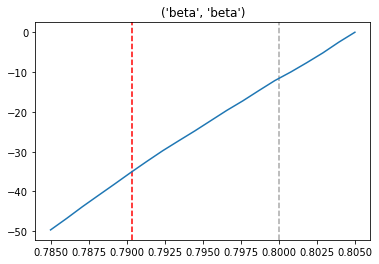

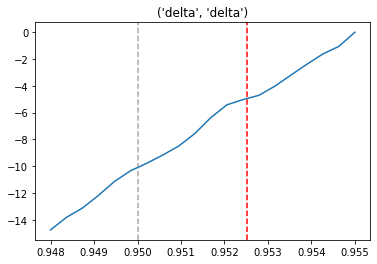

In [35]:
plot_profile_likelihood(results_obs, params_sim, estimates_obs)

The grey line indicates the true value, the red line indicates the value recovered by ML estimation.

***
*Lower beta*
***

In [36]:
# Set lower beta and generate dataset
params_lowbeta_ext = params_beta_ext.copy()
params_lowbeta_ext.loc[("beta", "beta"), "value"] = 0.4

simulate = rp.get_simulate_func(params_lowbeta_ext, options_ext)
df_lowbeta_ext = simulate(params_lowbeta_ext)

In [37]:
# Get the criterion function 
crit_func = rp.get_crit_func(params_lowbeta_ext, options_ext, df_lowbeta_ext)

In [38]:
results_lowbeta, estimates_lowbeta = maximize(
    crit_func, params_lowbeta_ext,
    "scipy_L-BFGS-B",
    algo_options={"maxfun": 100},
    constraints=constr,
    dashboard=False
)

In [43]:
estimated_params_lowbeta = pd.DataFrame(estimates_lowbeta["value"]).rename(columns={"value":"estimate"})
true_params = pd.DataFrame(params_lowbeta_ext["value"]).rename(columns={"value":"true value"})
comparison_lowbeta = pd.concat([estimated_params_lowbeta, true_params], axis=1)

comparison_lowbeta

estimate  true value
category                name                                            
beta                    beta                        0.359736        0.40
delta                   delta                       0.988639        0.95
wage_fishing            exp_fishing                 0.099919        0.10
                        contemplation_with_friday   0.346028        0.40
nonpec_fishing          constant                   -1.015283       -1.00
nonpec_friday           constant                   -0.977242       -1.00
                        not_fishing_last_period    -0.981571       -1.00
nonpec_hammock          constant                    2.491535        2.50
                        not_fishing_last_period    -0.973769       -1.00
shocks_sdcorr           sd_fishing                  0.989611        1.00
                        sd_friday                   1.065262        1.00
                        sd_hammock                  1.061619        1.00
                        corr_friday_fishing        -0.016653        0.00
                        corr_hammock_fishing       -0.018672        0.00
                        corr_hammock_friday         0.006709        0.00
lagged_choice_1_hammock constant                    1.000000        1.00
inadmissibility_penalty inadmissibility_penalty   -20.000000      -20.00

In [40]:
params_lowbeta_ext["lower"] = params_lowbeta_ext["value"].values
params_lowbeta_ext["upper"] = params_lowbeta_ext["value"].values
params_lowbeta_ext.loc[["beta", "delta"],"lower"] = [0.31, 0.949]
params_lowbeta_ext.loc[["beta", "delta"],"upper"] = [0.41, 1.01]

In [41]:
results_lowbeta = compute_profile_likelihood(params_lowbeta_ext, options_ext, df_lowbeta_ext)

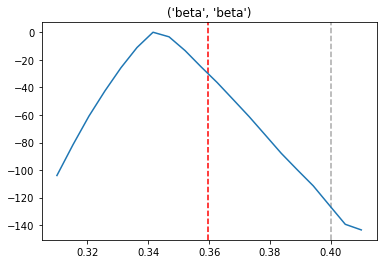

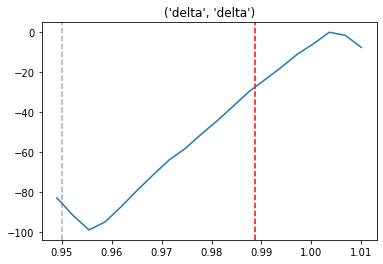

In [42]:
plot_profile_likelihood(results_lowbeta, params_lowbeta_ext, estimates_lowbeta)

The grey line indicates the true value, the red line indicates the value recovered by ML estimation.

## References 

Chan, M. K. (2017). [Welfare Dependence and Self-Control: An Empirical Analysis](https://doi.org/10.1093/restud/rdx011). *The Review of Economic Studies*, 84(4): 1379–1423.<br>

Fang, H., and Silverman, D. (2009). [Time-Inconsistency and Welfare Program Participation: Evidence from the NLSY](www.jstor.org/stable/25621500). *International Economic Review*, 50(4): 1043-1077.<br> 

Keane, M. P., Todd, P. E. and Wolpin, K. I. (2011). [The Structural Estimation of Behavioral Models: Discrete Choice Dynamic Programming Methods and Applications](https://doi.org/10.1016/S0169-7218(11)00410-2). Handbook of Labor Economics. 4: 331-461.<br>

Laibson, D.I. (1997). [Golden eggs and hyperbolic discounting](https://doi.org/10.1162/003355397555253). *Quarterly Journal of Economics*, 112(2): 443–77.<br>

Laibson, D.I., Repetto, A. and Tobacman, J. (2007). [Estimating Discount Functions with Consumption Choices Over the Lifecycle](https://ssrn.com/abstract=1008808). NBER Working Paper No. w13314. Available at SSRN.<br>

O'Donoghue, T. and Rabin, M. (1999). [Doing It Now or Later](https://doi.org/10.1257/aer.89.1.103). *American Economic Review*, 89(1): 103-124.<br>

Paserman, M. (2008). [Job Search and Hyperbolic Discounting: Structural Estimation and Policy Evaluation](www.jstor.org/stable/20108865). *The Economic Journal*, 118(531): 1418-1452.  

Phelps, E.S. and Pollak, R.A. (1968). [On second-best national saving and game-equilibrium growth](www.jstor.org/stable/2296547). *Review of Economic Studies*, 35(2): 185–99. 

Tarozzi, A., and Aprajit, M. (2011). [Time Inconsistency, Expectations and Technology Adoption: The Case of Insecticide Treated Nets](https://ssrn.com/abstract=1881106 ). *Economic Research Initiatives at Duke (ERID) Working Paper No. 105.* Available at SSRN.<br>